# **<center>Using CNN to stopping the car when it comes off the road<center>**
    
In this notebook, you can download images obtained with the donkey car. You can use them to launch a training in order to get a model for the donkey car.
Several options are available :

- The number of image to learn from
- The possibility to invert them to also learn turning right
    
    

In [8]:
import json
import shutil
import random
import pathlib
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display

import mlflow
import mlflow.tensorflow
import mlflow.keras

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MSLE, MAE, MSE
from tensorflow.keras.losses import MSE, MSLE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

from xebikart.images import transformer as T
import xebikart.dataset as dataset

%matplotlib inline

In [9]:
tf.__version__

'1.14.0'

In [10]:
tf.test.is_gpu_available()

False

Eager Execution allows to evaluate operations immediately without building graphs
note : Only needed when not using TF 2.0

In [11]:
tf.enable_eager_execution()

In [16]:
# parameters
# dataset parameters
tubes_root_folder = 'file:/workspace/xebikart-ml-tubes'
tubes_folders_road = ["tub.v7.01", "tub.v7.02"]
tubes_folders_exit = ["tub.v5.01", "tub.v5.02", "tub.v4.01", "tub.v4.02", "tub.v5.03"]# "tub.v5.04"

test_size=0.2

# training parameters
batch_size = 32
shuffle_size = 200
n_epochs = 50
learning_rate = 1e-3

# Load data

Download tubes from : https://github.com/xebia-france/xebikart-ml-tubes

In [17]:
%%capture
road_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders_road, tubes_extension=".tar.gz")
road_tubes_df['label'] = 0
exit_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders_exit, tubes_extension=".tar.gz")
exit_tubes_df['label'] = 1
road_tubes_df = road_tubes_df.rename(columns={"cam/image_array": "images_path"})
exit_tubes_df = exit_tubes_df.rename(columns={"cam/image_array": "images_path"})
tubes_df = pd.concat([road_tubes_df, exit_tubes_df]).reset_index(drop=True)
tubes_df = tubes_df.drop(["user/angle", "user/throttle", "user/mode", "timestamp", 'num_tube'], axis=1)

In [18]:
tubes_df.head()

,images_path,label
0,/root/.keras/datasets/tub.v7.01/0_cam-image_ar...,0
1,/root/.keras/datasets/tub.v7.01/1_cam-image_ar...,0
2,/root/.keras/datasets/tub.v7.01/2_cam-image_ar...,0
3,/root/.keras/datasets/tub.v7.01/3_cam-image_ar...,0
4,/root/.keras/datasets/tub.v7.01/4_cam-image_ar...,0


#### **- Display some examples**

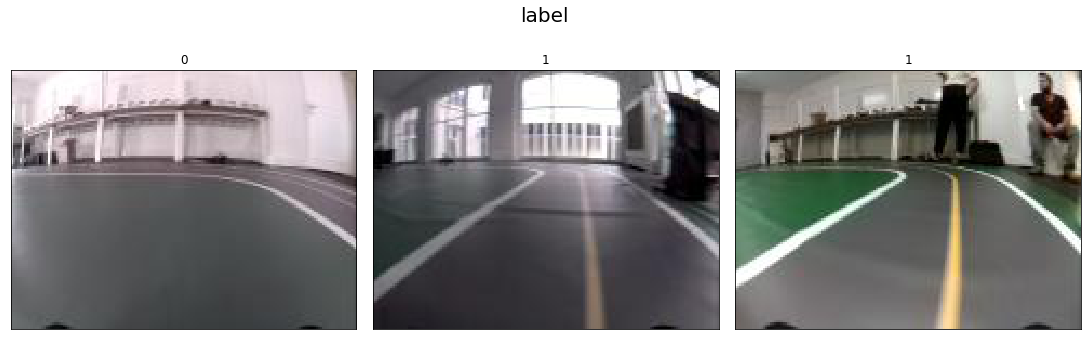

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)
fig.suptitle("label", fontsize=20)

for n, sample in tubes_df.sample(3).reset_index().iterrows():
    random_image_path = sample["images_path"]
    label = sample["label"]
    image = mpimg.imread(random_image_path) 
    axs[n].set_title(label)
    axs[n].imshow(image)
    axs[n].get_xaxis().set_visible(False)
    axs[n].get_yaxis().set_visible(False)

#### **- Display some sample distribution**

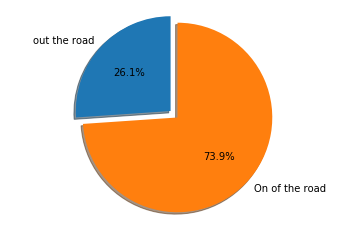

In [24]:
labels = 'out the road', 'On of the road'
sizes = [len(tubes_df[tubes_df.label == 0]), len(tubes_df[tubes_df.label == 1])]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Preprocessing Images

In [25]:
crop_fn = T.generate_crop_fn(left_margin=0, width=160, height_margin=40, height=80)

def load_augmentation_preprocess(image_path):
    tf_image = T.read_image(image_path)
    tf_image = T.normalize(tf_image)
    tf_image = tf.image.rgb_to_grayscale(tf_image)
    tf_image = crop_fn(tf_image)
    return tf_image

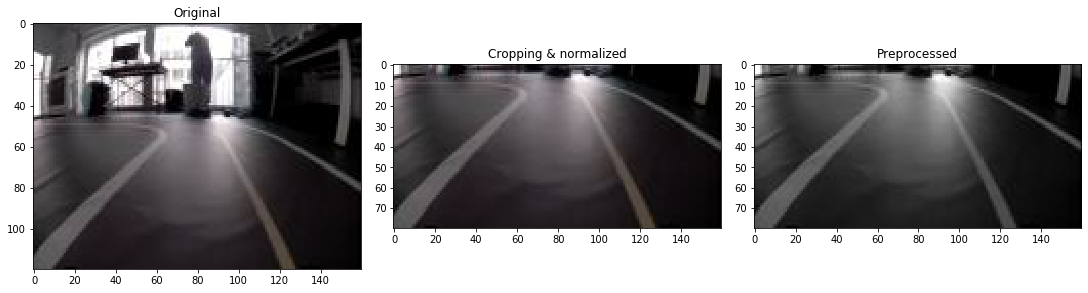

In [30]:
random_image_path = tubes_df.sample()["images_path"].values[0]

tf_image_original   = T.read_image(random_image_path)
tf_image_normalized = T.normalize(tf_image_original)
tf_image_cropped    = crop_fn(tf_image_normalized)
tf_image_grayscaled = tf.image.rgb_to_grayscale(tf_image_cropped)

fig, axs = plt.subplots(1, 3, figsize=(15,15), constrained_layout=True)
axs[0].set_title("Original")
axs[0].imshow(tf_image_original)
axs[1].set_title("Cropping & normalized")
axs[1].imshow(tf_image_cropped)
axs[2].set_title("Preprocessed")
axs[2].imshow(tf_image_grayscaled[:,:,0],cmap='gray')
plt.show()

# Build a dataset of images

#### **- Split data into test/train datasets**

Note : We only use angle as label

In [31]:
images_path = tubes_df["images_path"].tolist()
label = tubes_df["label"].tolist()

In [32]:
train_images_path, test_images_path, train_metas, test_metas = train_test_split(images_path, label, test_size=test_size)
print('Train set :', len(train_images_path), 'images')
print('Test set :', len(test_images_path), 'images')

Train set : 11716 images
Test set : 2930 images


#### **- Create tensor for train and test datasets**

In [33]:
def input_fn(filepath, label, BATCH_SIZE = 32, SHUFFLE_SIZE = 200, NUM_EPOCHS = 50):
    ds_x = tf.data.Dataset.from_tensor_slices(filepath)
    ds_x = ds_x.map(load_augmentation_preprocess)
    ds_y = tf.data.Dataset.from_tensor_slices(label)
    ds_x_y = tf.data.Dataset.zip((ds_x, ds_y)).shuffle(SHUFFLE_SIZE).repeat(NUM_EPOCHS).batch(BATCH_SIZE).prefetch(1)
    
    return ds_x_y

In [34]:
ds_train = input_fn(train_images_path, train_metas)
ds_test = input_fn(test_images_path, test_metas, NUM_EPOCHS=1)

# Build Model

In [53]:
model = Sequential()

model.add(Conv2D(16, (5), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(80, 160, 1)))
model.add(MaxPooling2D(3, 3))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(MaxPooling2D(3, 3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(MaxPooling2D(3, 3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 76, 156, 16)       416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 52, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 16, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 14, 64)         18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)              

In [54]:
model.compile(optimizer=Adam(learning_rate=learning_rate, decay=learning_rate/n_epochs), loss="binary_crossentropy")

In [55]:
mlflow.set_experiment("detect_road_exit_V2")

with mlflow.start_run():
    mlflow.log_params({
        "images_exit": str(tubes_folders_exit),
        "images_road": str(tubes_folders_road),
        "nb_images": len(train_images_path),
        "epochs": n_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        'gray': True,
    })
    mlflow.tensorflow.autolog()
    history = model.fit(x=ds_train,
                    steps_per_epoch=len(train_metas)//batch_size,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=ds_test,
                    validation_steps=len(test_metas)//batch_size)

Epoch 1/50
366/366 [==============================] - 38s 105ms/step - loss: 1.4439 - val_loss: 0.2554
Epoch 2/50
366/366 [==============================] - 39s 107ms/step - loss: 0.2527 - val_loss: 0.2060
Epoch 3/50
366/366 [==============================] - 39s 106ms/step - loss: 0.2133 - val_loss: 0.2094
Epoch 4/50
366/366 [==============================] - 35s 96ms/step - loss: 0.1916 - val_loss: 0.1707
Epoch 5/50
366/366 [==============================] - 39s 106ms/step - loss: 0.1828 - val_loss: 0.1580
Epoch 6/50
366/366 [==============================] - 41s 112ms/step - loss: 0.1722 - val_loss: 0.1459
Epoch 7/50
366/366 [==============================] - 40s 109ms/step - loss: 0.1675 - val_loss: 0.1452
Epoch 8/50
366/366 [==============================] - 38s 105ms/step - loss: 0.1649 - val_loss: 0.1415
Epoch 9/50
366/366 [==============================] - 35s 97ms/step - loss: 0.1549 - val_loss: 0.1294
Epoch 10/50
366/366 [==============================] - 35s 95ms/step - loss

# Plot loss

In [38]:
model.evaluate(ds_test)

92/92 [==============================] - 3s 37ms/step - loss: 0.1066


0.10656804567121941

In [56]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=['loss','val_loss']
    hist_df.index = np.arange(1, len(hist_df)+1)
    fig = plt.figure(figsize=(10,5))
    plt.plot(hist_df.val_loss, lw=3, label='Validation Loss')
    plt.plot(hist_df.loss, lw=3, label='Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc=0)

    plt.show()

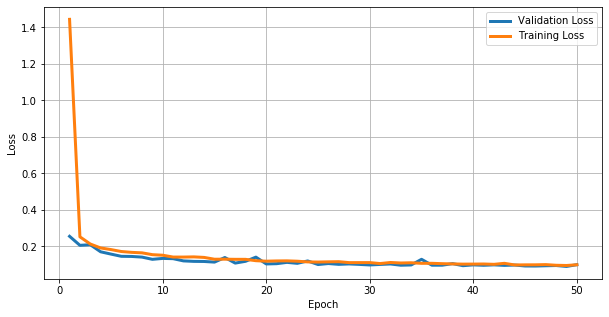

In [57]:
plot_results(history)

# Evaluation & Visualisation

### - Prediction

In [58]:
test_pred = model.predict(ds_test, use_multiprocessing=True, workers=12, steps = None)#len(test_metas)/batch_size)

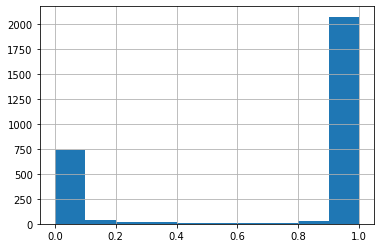

In [59]:
df = pd.DataFrame(test_pred, columns = ['label'])
df.label.hist()

### - Visualisation predictions

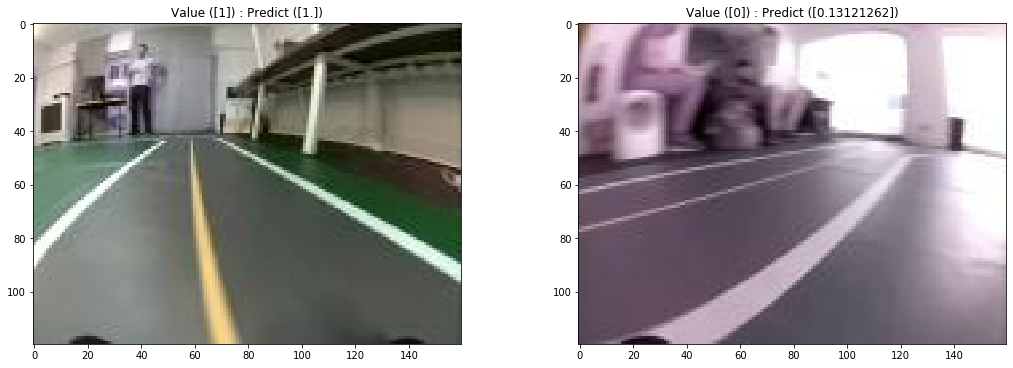

In [73]:
nb_random = np.random.randint(len(test_metas))

random_image_path_0 = [(test_images_path[nb_random])]
random_image_label_0 = [test_metas[nb_random]]

ds_visu_test_0 = input_fn(random_image_path_0, random_image_label_0)

nb_random = np.random.randint(len(test_metas))

random_image_path_1 = [(test_images_path[nb_random])]
random_image_label_1 = [test_metas[nb_random]]

ds_visu_test_1 = input_fn(random_image_path_1, random_image_label_1)

fig, axs = plt.subplots(1, 2, figsize=(15,5), constrained_layout=True)
axs[0].set_title("Value ({}) : Predict ({})".format(random_image_label_0, model.predict(ds_visu_test_0)[0]))
axs[0].imshow(T.read_image(random_image_path_0[0]))
axs[1].set_title("Value ({}) : Predict ({})".format(random_image_label_1, model.predict(ds_visu_test_1)[0]))
axs[1].imshow(T.read_image(random_image_path_1[0]))

plt.show()

### - Interpretation results

In [31]:
precision, recall, thresholds = precision_recall_curve(y_true=test_metas, probas_pred=test_pred)

NameError: name 'test_pred' is not defined

In [ ]:
plt.plot(thresholds, precision[:-1], '--', label='precision')
plt.plot(thresholds, recall[:-1], '--', label='recall')
plt.xlabel('threshold')
plt.legend()

plt.show()